In [1]:
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
import cartopy as cy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from geopy import distance
import math
import re

In [2]:
OPeNDAP_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/mywavewam800n/MyWave_wam800_c1SPC00.nc'
ds =  xr.open_dataset(OPeNDAP_url)
ds

<xarray.Dataset> Size: 446MB
Dimensions:                  (direction: 36, freq: 36, x: 1171, y: 1, time: 73)
Coordinates:
  * direction                (direction) float32 144B 5.0 15.0 ... 345.0 355.0
  * freq                     (freq) float32 144B 0.03452 0.03798 ... 0.9702
  * x                        (x) int32 5kB 1 2 3 4 5 ... 1168 1169 1170 1171
  * y                        (y) int32 4B 1
  * time                     (time) datetime64[ns] 584B 2024-12-22T18:00:00 ....
    latitude                 (y, x) float32 5kB ...
    longitude                (y, x) float32 5kB ...
Data variables:
    forecast_reference_time  datetime64[ns] 8B ...
    SPEC                     (time, y, x, freq, direction) float32 443MB ...
    Pdir                     (time, y, x) float32 342kB ...
    dd                       (time, y, x) float32 342kB ...
    depth                    (y, x) float32 5kB ...
    ff                       (time, y, x) float32 342kB ...
    hs                       (time, y, x) float32 342kB ...
    thq_sea                  (time, y, x) float32 342kB ...
    thq_swell                (time, y, x) float32 342kB ...
    tp                       (time, y, x) float32 342kB ...
Attributes:
    title:                           MyWaveWam 800m NordNorge
    institution:                     Norwegian Meteorological Institute
    source:                          WAM wave model version cycle 4.7.0
    direction_convention:            A direction of 0 degrees means a wave pr...
    history:                         Mon Dec 23 04:28:06 2024: ncks -A -v for...
    history_of_appended_files:       Mon Dec 23 04:28:06 2024: Appended file ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

# Fidning the closesest grid point with spectra to the beach of interest: Unstad
The data is bascially 1-d array with x coordinate, for wich longitude and latitude  of  
not a trivial task since some points do not have spectrum values (see code below) 
The chosen point is markes x_spec  

https://www.surfline.com/surf-report/unstad-beach/584204204e65fad6a770960c

In [3]:
#Unstad surfing beach is my point of interest
point_of_interest_lat = 68.269936
point_of_interest_lon  = 13.578450
# those values are experimental, I looke it up on a map... :(
delta_lat = 0.2
delta_lon = 0.7
left_limit_lat = round(point_of_interest_lat,1) -delta_lat
right_limit_lat = round(point_of_interest_lat,1) + delta_lat
left_limit_lon = round(point_of_interest_lon,1) - delta_lon
right_limit_lon = round(point_of_interest_lon,1) + delta_lon

# I am intereste in x coorintate
lat_indices_x = ds.latitude.where((ds.latitude >= left_limit_lat) & (ds.latitude <= right_limit_lat), drop=True).x
lon_indices_x = ds.longitude.where((ds.longitude >= left_limit_lon) & (ds.longitude <= right_limit_lon), drop=True).x
intersection = np.intersect1d(lat_indices_x.values, lon_indices_x.values)
intersection

array([ 831, 1152], dtype=int32)

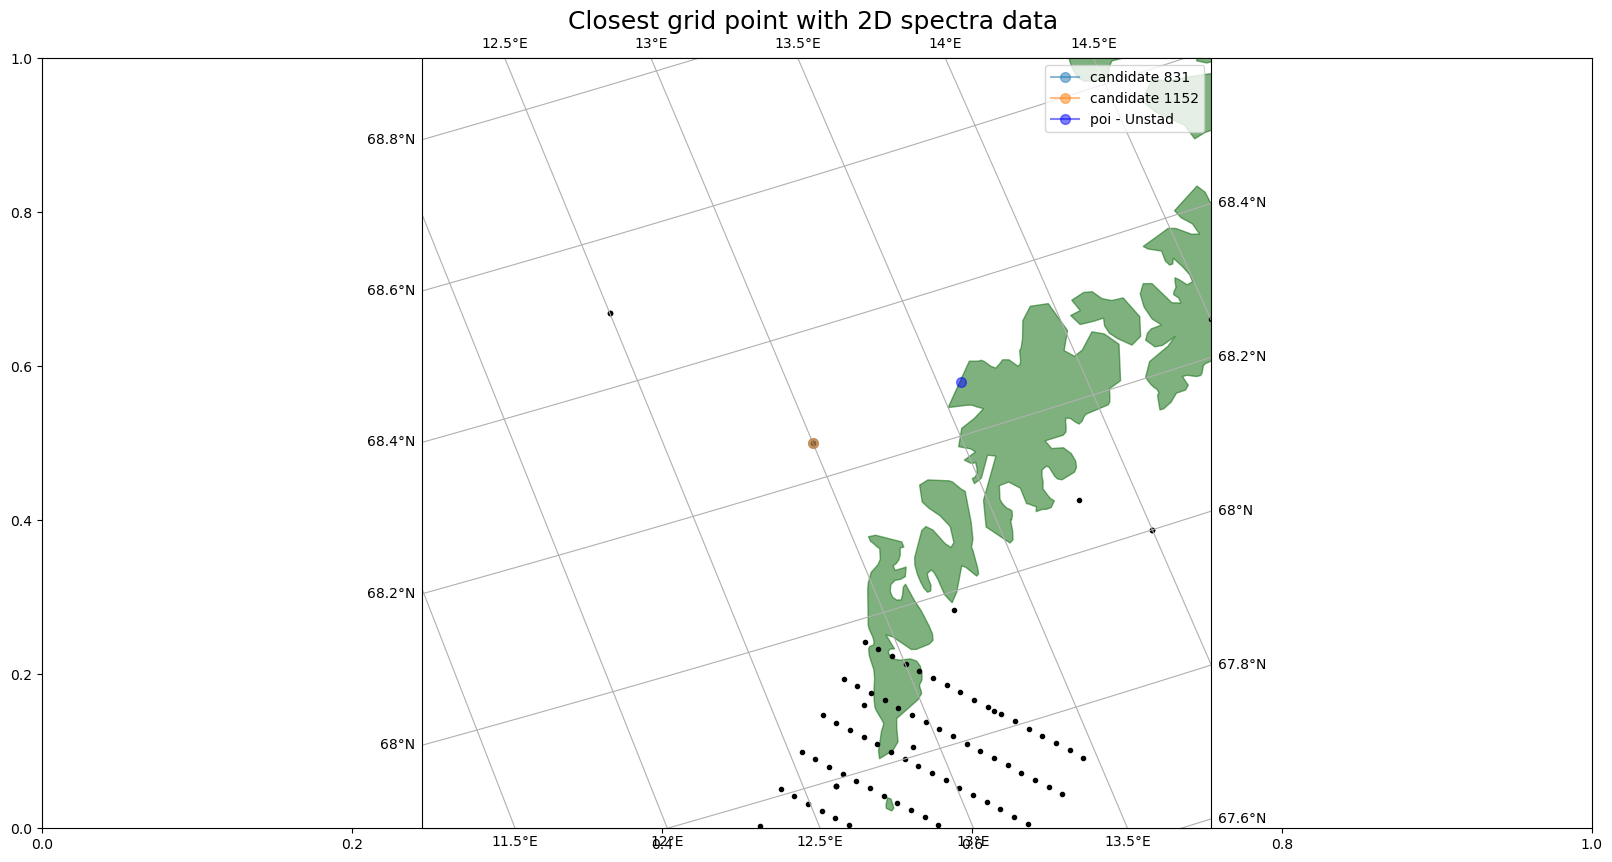

In [4]:
#defining my area of interestes, Lofoten archipelago, area surrounding beach of interest - Unstad
area_min_lon, area_max_lon, area_min_lat, area_max_lat = (12, 14, 67.8, 68.7)

fig, ax = plt.subplots(figsize=(20, 10))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.Orthographic(-10, 45))
ax.axes.set_extent([area_min_lon, area_max_lon, area_min_lat, area_max_lat], crs=proj)

ax.add_feature(cfeature.LAND,color='darkgreen', alpha = 0.5)
ax.gridlines(draw_labels=True)
#ax.coastlines(resolution='50m', color='darkkhaki', linewidth=0.5)
res = ax.scatter(ds.longitude,ds.latitude,marker='.', color='black', transform=ccrs.PlateCarree())
for x_spec in intersection:
    ax.plot(ds.longitude.sel(x = x_spec), ds.latitude.sel(x = x_spec), marker='o', alpha = 0.5, markersize=7, label=f"candidate {x_spec}", transform=ccrs.PlateCarree())
ax.plot(point_of_interest_lon, point_of_interest_lat, marker='o', color='blue', alpha = 0.5, markersize=7, label="poi - Unstad", transform=ccrs.PlateCarree())
plt.legend()
plt.title(f'Closest grid point with 2D spectra data ',fontsize=18)
plt.show()

In [5]:
spec_x = intersection[0]
spectrum_point_lon = ds.longitude.sel(x = spec_x)
spectrum_point_lat = ds.latitude.sel(x = spec_x)
distance.distance((point_of_interest_lon, point_of_interest_lat),(spectrum_point_lon, spectrum_point_lat))

Distance(64.03241228563176)

In [6]:
#unfortuntaely there are no spectrum values
E = ds.isel(time = 1,  x = spec_x, y = 0)['SPEC'].values
E

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [7]:
lat_indices_x = ds.latitude.where((ds.latitude >= 68.4) & (ds.latitude <= 68.5), drop=True).x
lon_indices_x = ds.longitude.where((ds.longitude >= 12.4) & (ds.longitude <= 12.6), drop=True).x
intersection = np.intersect1d(lat_indices_x.values, lon_indices_x.values)
intersection

array([ 833, 1153], dtype=int32)

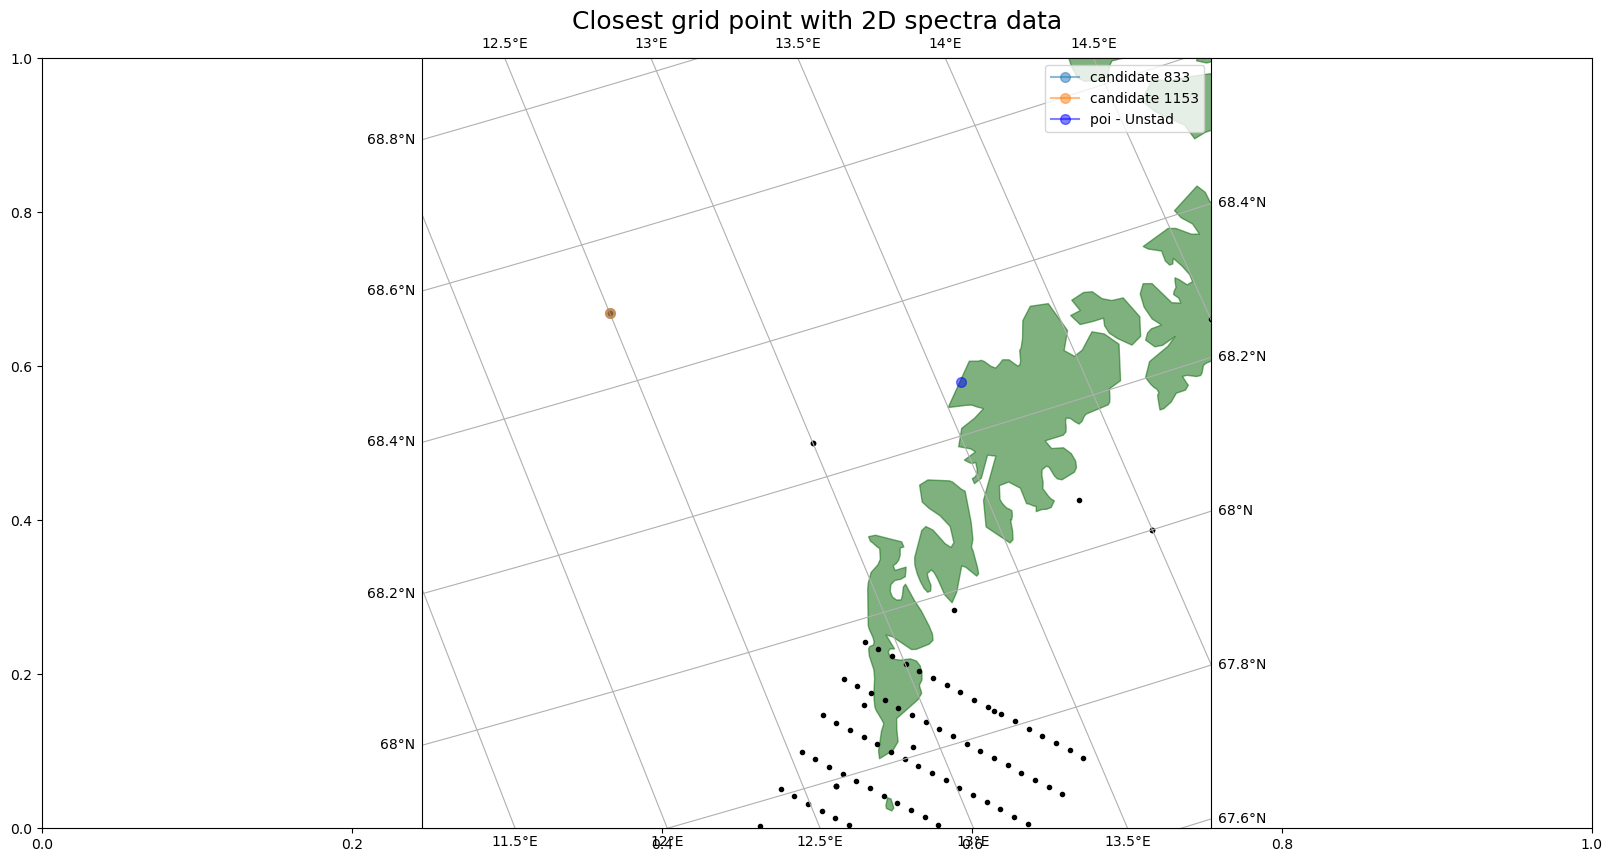

In [8]:
#defining my area of interestes, Lofoten archipelago, area surrounding beach of interest - Unstad
area_min_lon, area_max_lon, area_min_lat, area_max_lat = (12, 14, 67.8, 68.7)

fig, ax = plt.subplots(figsize=(20, 10))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.Orthographic(-10, 45))
ax.axes.set_extent([area_min_lon, area_max_lon, area_min_lat, area_max_lat], crs=proj)

ax.add_feature(cfeature.LAND,color='darkgreen', alpha = 0.5)
ax.gridlines(draw_labels=True)
#ax.coastlines(resolution='50m', color='darkkhaki', linewidth=0.5)
res = ax.scatter(ds.longitude,ds.latitude,marker='.', color='black', transform=ccrs.PlateCarree())
for x_spec in intersection:
    ax.plot(ds.longitude.sel(x = x_spec), ds.latitude.sel(x = x_spec), marker='o', alpha = 0.5, markersize=7, label=f"candidate {x_spec}", transform=ccrs.PlateCarree())
ax.plot(point_of_interest_lon, point_of_interest_lat, marker='o', color='blue', alpha = 0.5, markersize=7, label="poi - Unstad", transform=ccrs.PlateCarree())
plt.legend()
plt.title(f'Closest grid point with 2D spectra data',fontsize=18)
plt.show()

In [9]:
spec_x = 833
E = ds.isel(time = 1,  x = 833, y = 0)['SPEC'].values
E

array([[6.6067291e-06, 7.4568279e-06, 8.1892422e-06, ..., 3.8274243e-06,
        5.3197159e-06, 6.1609567e-06],
       [3.7190810e-04, 4.2334411e-04, 4.6387082e-04, ..., 1.8650859e-04,
        2.8034806e-04, 3.3917191e-04],
       [7.1124444e-03, 8.1692915e-03, 8.8845603e-03, ..., 2.9987651e-03,
        4.8885192e-03, 6.2818611e-03],
       ...,
       [4.8081223e-05, 6.8513959e-06, 6.1248289e-07, ..., 5.7963631e-04,
        3.6594656e-04, 1.7438900e-04],
       [2.9854651e-05, 4.2541769e-06, 3.8030359e-07, ..., 3.5990850e-04,
        2.2722398e-04, 1.0828184e-04],
       [1.8537390e-05, 2.6415096e-06, 2.3613862e-07, ..., 2.2347487e-04,
        1.4108823e-04, 6.7234505e-05]], dtype=float32)

In [10]:
ds.freq.values

array([0.034523  , 0.0379753 , 0.04177283, 0.04595011, 0.05054513,
       0.05559964, 0.06115961, 0.06727557, 0.07400313, 0.08140344,
       0.08954379, 0.09849817, 0.10834799, 0.11918279, 0.13110107,
       0.14421119, 0.15863231, 0.17449555, 0.1919451 , 0.21113962,
       0.23225358, 0.25547895, 0.28102684, 0.30912954, 0.3400425 ,
       0.37404677, 0.41145146, 0.4525966 , 0.4978563 , 0.54764193,
       0.60240614, 0.6626468 , 0.72891146, 0.80180264, 0.8819829 ,
       0.9701812 ], dtype=float32)

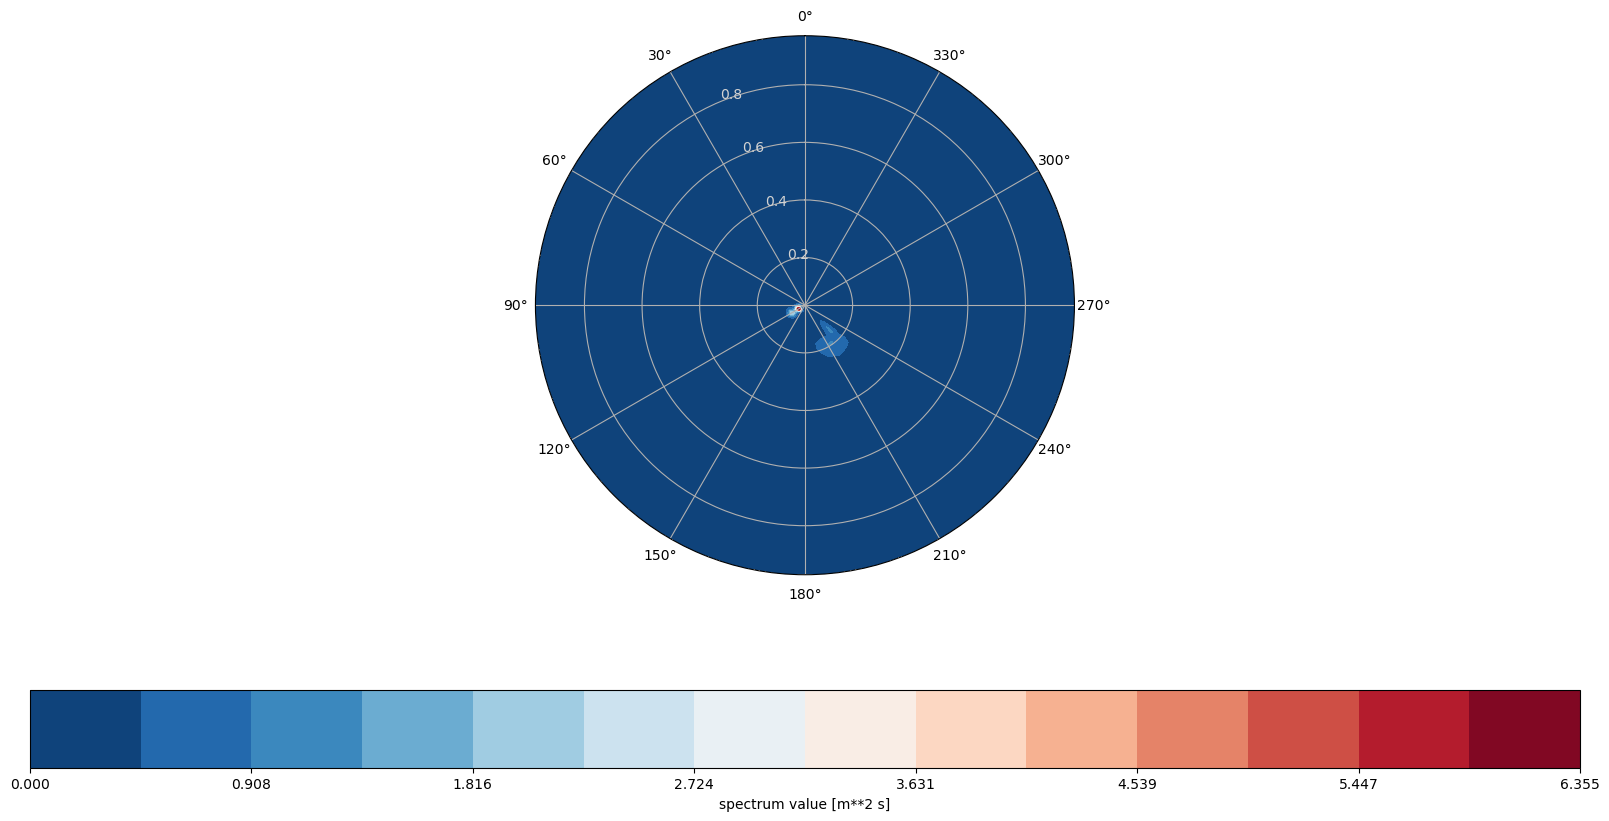

In [11]:
#thetas are 0-360-step angle values expressed in radians thus 0-2pi- step
thetas = [math.radians(deg) for deg in ds.direction.values]
#frequencies are discrete frequencies - equvanet to 1.03 - 28.9 s periods
freqencies = ds.freq.values
time_index = 0
E = ds.isel(time = time_index,  x = spec_x, y = 0)['SPEC'].values.T

# since thetas are not exactly from 0 to 360, extra step must be added, otherwise the spectrum plot would be wedged
dtheta = np.diff(thetas).mean() # / theta step, they are rather equal
wrapped_theta = np.concatenate((thetas, thetas[-1:] + dtheta))
wrapped_E = np.concatenate((E, E[0:1, :]), axis=0)

#generating meshgrid
[r_coord, th_coord] = np.meshgrid(freqencies,wrapped_theta)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, polar = True)
#beautifying the polar plot 
ax.set_theta_zero_location('N')
ax.set_theta_direction(+1)
ax.tick_params(axis='y', labelcolor='lightgrey', colors='lightgrey')

ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))

cntf = ax.contourf(th_coord, r_coord, wrapped_E, cmap='RdBu_r', 
                   levels=np.linspace(np.min(E), np.max(E), 15))

_ = fig.colorbar(cntf, ax=ax, orientation='horizontal', label='spectrum value [m**2 s]')

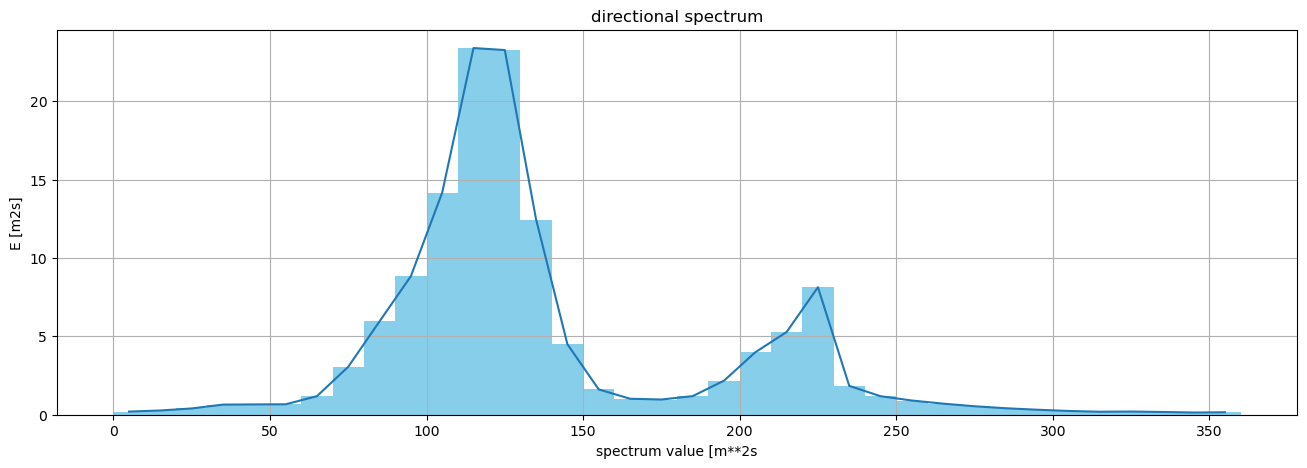

In [12]:
fig, (ax) = plt.subplots(1, 1, figsize=(16, 5)) 
E = ds.isel(time = time_index,  x = spec_x, y = 0)['SPEC'].values
energy_sum_by_deg = np.sum(E, axis=0)
ax.bar(ds.direction.values, energy_sum_by_deg, width=10, color = 'skyblue')  
ax.plot(ds.direction.values, energy_sum_by_deg)

#ax.fill_between(ds.direction.values, deg_total_energy, color="skyblue", alpha=0.4)
ax.set_title("directional spectrum")
ax.set_xlabel("direction [degrees]")
ax.set_xlabel("spectrum value [m**2s")
ax.set_ylabel("E [m2s]")
ax.grid(True)

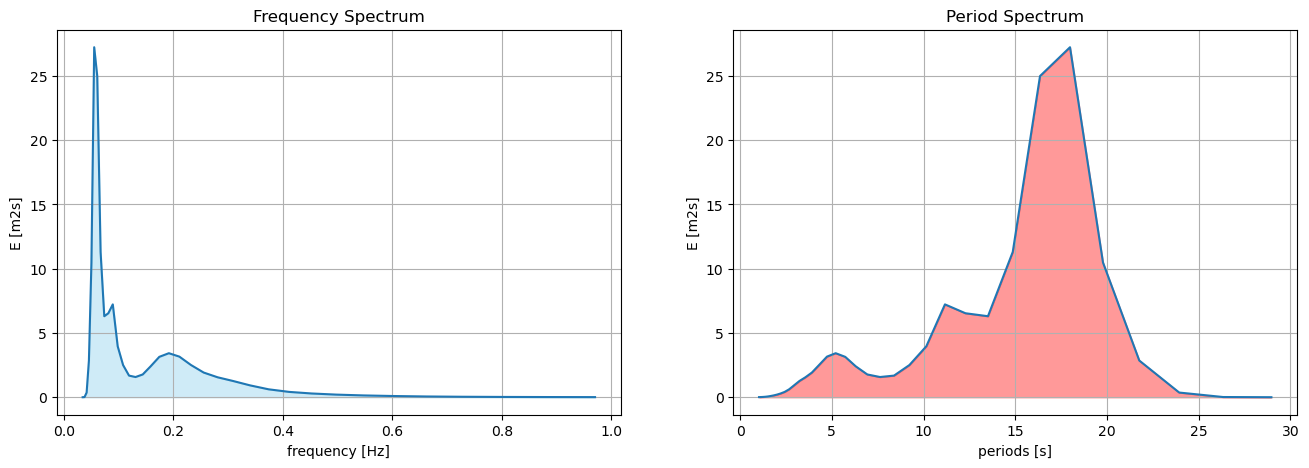

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5)) 
energy_sum_by_freq = np.sum(E, axis=1)
ax1.plot(ds.freq.values, energy_sum_by_freq)
ax1.fill_between(ds.freq.values, energy_sum_by_freq, color="skyblue", alpha=0.4)
ax1.set_title("Frequency Spectrum")
ax1.set_ylabel("E [m2s]")
ax1.set_xlabel("frequency [Hz]")
ax1.grid(True)

periods = 1/ds.freq.values
ax2.set_ylabel("E [m2s]")
ax2.set_title("Period Spectrum")
ax2.set_xlabel("periods [s]")
ax2.plot(periods, energy_sum_by_freq)
ax2.fill_between(periods, energy_sum_by_freq, color="red", alpha=0.4)
ax2.grid(True)

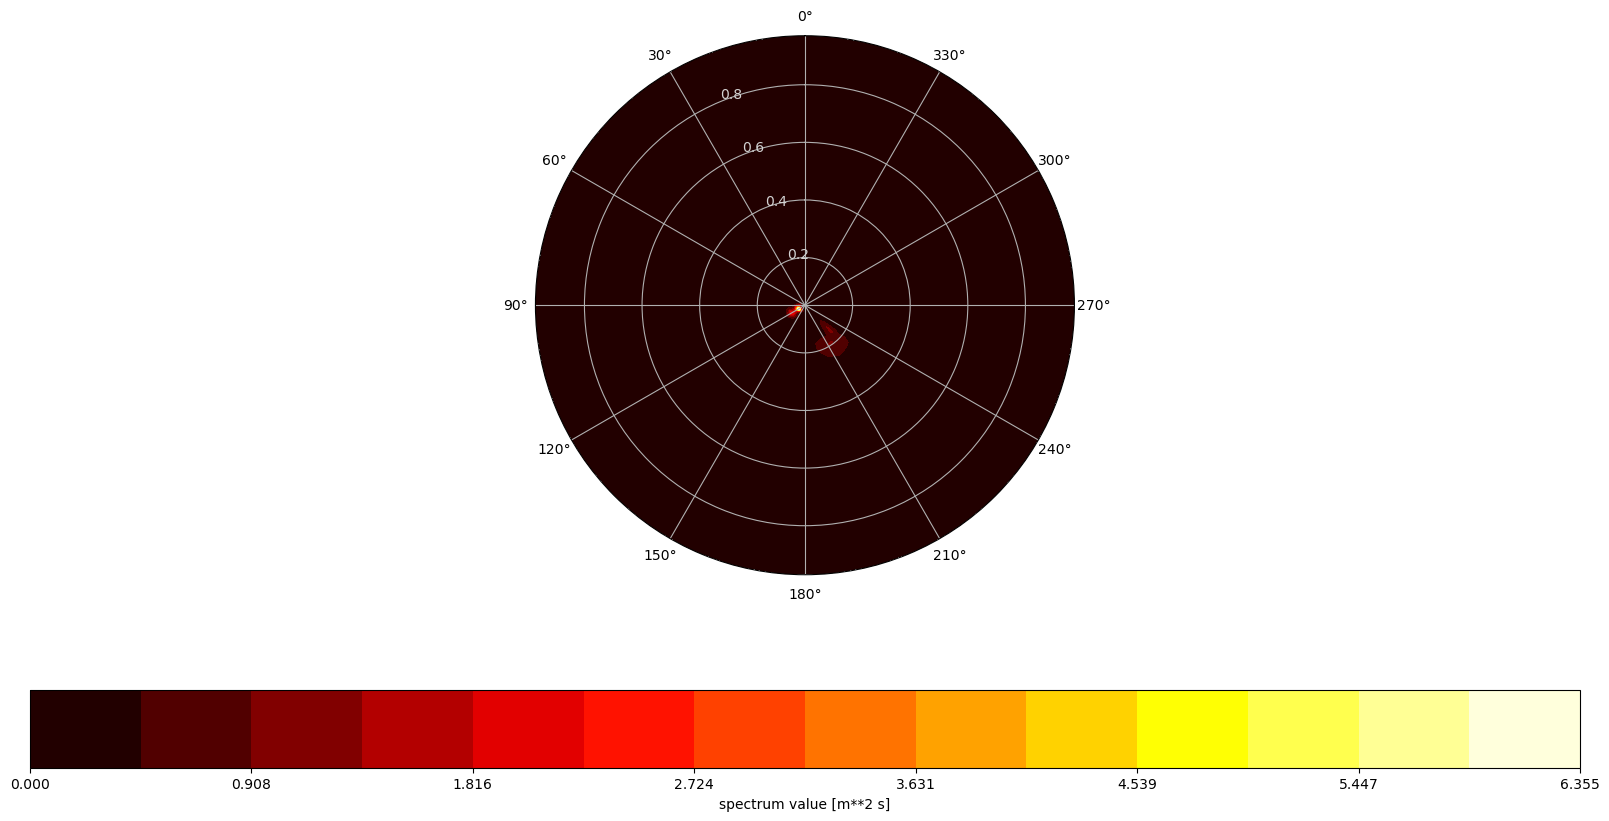

In [14]:
#thetas are 0-360-step angle values expressed in radians thus 0-2pi- step
thetas = [math.radians(deg) for deg in ds.direction.values]
#frequencies are discrete frequencies - equvanet to 1.03 - 28.9 s periods
freqencies = ds.freq.values
time_index = 0

E = ds.isel(time = time_index,  x = spec_x, y = 0)['SPEC'].values.T

# since thetas are not exactly from 0 to 360, extra step must be added, otherwise the spectrum plot would be wedged
dtheta = np.diff(thetas).mean() # / theta step, they are rather equal
wrapped_theta = np.concatenate((thetas, thetas[-1:] + dtheta))
wrapped_E = np.concatenate((E, E[0:1, :]), axis=0)

#generating meshgrid
[r_coord, th_coord] = np.meshgrid(freqencies,wrapped_theta)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, polar = True)
#beautifying the polar plot 
ax.set_theta_zero_location('N')
ax.set_theta_direction(+1)
ax.tick_params(axis='y', labelcolor='lightgrey', colors='lightgrey')

ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))

cntf = ax.contourf(th_coord, r_coord, wrapped_E, cmap='hot', 
                   levels=np.linspace(np.min(E), np.max(E), 15))

_ = fig.colorbar(cntf, ax=ax, orientation='horizontal', label='spectrum value [m**2 s]')